In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms


## 確認裝置

In [2]:
# 1. 裝置設定
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"使用裝置：{device}")

使用裝置：cuda:0


## 下載資料集

In [ ]:
# 2. 資料前處理與載入
transform = transforms.Compose([
    transforms.ToTensor(),  # 直接將像素從 [0,255] => [0,1]
])

trainset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=128, shuffle=False, num_workers=2)


82.1%

In [247]:
"""
class CNN2(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        act = nn.ReLU()  # 或改成 nn.ReLU()

        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 32x32 -> 32x32
            #nn.BatchNorm2d(64),
            act,
            nn.MaxPool2d(2, 2)                           # 32x32 -> 16x16
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 16x16 -> 16x16
            #nn.BatchNorm2d(128),
            act,
            nn.MaxPool2d(2, 2)                           # 16x16 -> 8x8
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),# 8x8 -> 8x8
            #nn.BatchNorm2d(256),
            act
        )
        self.block4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),# 8x8 -> 8x8
            #nn.BatchNorm2d(256),
            act
        )

        self.gap = nn.AdaptiveAvgPool2d(1)  # 8x8 -> 1x1
        self.fc1 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.block1(x)   # (B,64,16,16)
        x = self.block2(x)   # (B,128,8,8)
        x = self.block3(x)   # (B,256,8,8)
        x = self.gap(x)      # (B,256,1,1)
        x = x.view(x.size(0), -1)  # (B,256)
        x = self.fc1(x)      # (B,num_classes)
        return x
model2 = CNN2().to(device)
print(model2)
# 4. 損失與優化器
criterion = nn.CrossEntropyLoss()  # 直接接收整數標籤
optimizer = optim.Adam(model2.parameters(), lr=0.001)
"""

'\nclass CNN2(nn.Module):\n    def __init__(self, num_classes=10):\n        super().__init__()\n        act = nn.ReLU()  # 或改成 nn.ReLU()\n\n        self.block1 = nn.Sequential(\n            nn.Conv2d(3, 64, kernel_size=3, padding=1),  # 32x32 -> 32x32\n            #nn.BatchNorm2d(64),\n            act,\n            nn.MaxPool2d(2, 2)                           # 32x32 -> 16x16\n        )\n        self.block2 = nn.Sequential(\n            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 16x16 -> 16x16\n            #nn.BatchNorm2d(128),\n            act,\n            nn.MaxPool2d(2, 2)                           # 16x16 -> 8x8\n        )\n        self.block3 = nn.Sequential(\n            nn.Conv2d(128, 256, kernel_size=3, padding=1),# 8x8 -> 8x8\n            #nn.BatchNorm2d(256),\n            act\n        )\n        self.block4 = nn.Sequential(\n            nn.Conv2d(128, 256, kernel_size=3, padding=1),# 8x8 -> 8x8\n            #nn.BatchNorm2d(256),\n            act\n        )\n\n        sel

In [248]:
import torch
import torch.nn as nn
import torch.optim as optim

# 3. 模型定義
class CNN100(nn.Module):
    def __init__(self, num_classes=10, p_drop=0.3):
        super().__init__()
        # Block1: 3x32x32 -> 64x32x32 -> Pool -> 64x16x16
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # Block2: 64x16x16 -> 128x16x16 -> Pool -> 128x8x8
        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2)
        )
        # Block3: 128x8x8 -> 256x8x8 -> Dropout2d
        self.block3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p_drop)
        )
        # Block4: 256x8x8 -> 512x8x8  （原本你這層有再 pool；保留表現我先不池化）
        self.block4 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )

        # 全域平均 + 全連接
        self.gap = nn.AdaptiveAvgPool2d(1)   # -> (B,512,1,1)
        self.fc1 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block1(x)   # (B,64,16,16)
        x = self.block2(x)   # (B,128,8,8)
        x = self.block3(x)   # (B,256,8,8)
        x = self.block4(x)   # (B,512,8,8)
        x = self.gap(x)      # (B,512,1,1)
        x = torch.flatten(x, 1)  # (B,512)
        x = self.fc1(x)      # (B, num_classes)
        return x

# 建立模型/損失/優化器
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = CNN100().to(device)
print(model2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model2.parameters(), lr=1e-3)


CNN100(
  (block1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Dropout2d(p=0.3, inplace=False)
  )
  (block4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1)

Epoch 1/20 — Train Loss: 1.3086, Train Acc: 0.5228 — Val Loss: 1.2209, Val Acc: 0.5541
Epoch 2/20 — Train Loss: 1.0147, Train Acc: 0.6385 — Val Loss: 1.1883, Val Acc: 0.5937
Epoch 3/20 — Train Loss: 0.8838, Train Acc: 0.6871 — Val Loss: 1.1156, Val Acc: 0.6077
Epoch 4/20 — Train Loss: 0.7893, Train Acc: 0.7228 — Val Loss: 0.9326, Val Acc: 0.6775
Epoch 5/20 — Train Loss: 0.7243, Train Acc: 0.7472 — Val Loss: 1.0441, Val Acc: 0.6440
Epoch 6/20 — Train Loss: 0.6591, Train Acc: 0.7692 — Val Loss: 0.8567, Val Acc: 0.7057
Epoch 7/20 — Train Loss: 0.6029, Train Acc: 0.7908 — Val Loss: 1.1957, Val Acc: 0.6071
Epoch 8/20 — Train Loss: 0.5529, Train Acc: 0.8081 — Val Loss: 0.9947, Val Acc: 0.6720
Epoch 9/20 — Train Loss: 0.5146, Train Acc: 0.8210 — Val Loss: 0.6562, Val Acc: 0.7726
Epoch 10/20 — Train Loss: 0.4729, Train Acc: 0.8346 — Val Loss: 1.0990, Val Acc: 0.6708
Epoch 11/20 — Train Loss: 0.4424, Train Acc: 0.8479 — Val Loss: 1.1584, Val Acc: 0.6668
Epoch 12/20 — Train Loss: 0.4054, Train A

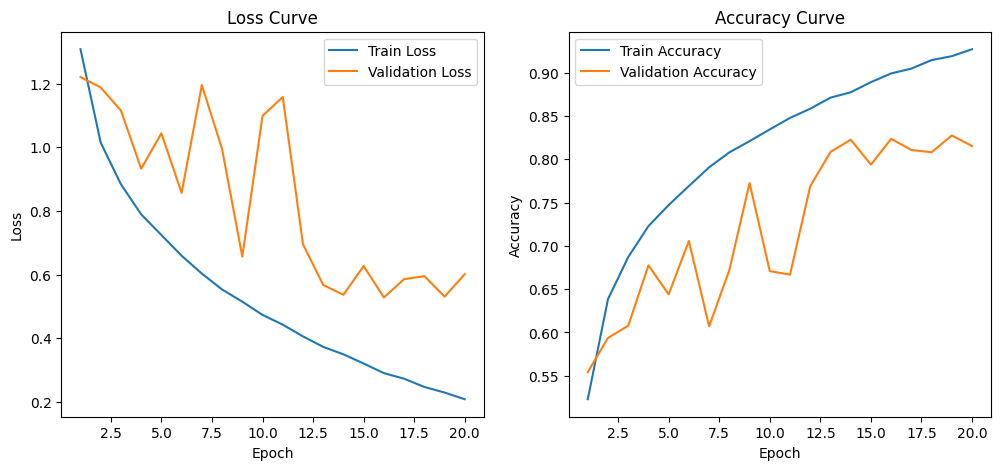

In [249]:
import matplotlib.pyplot as plt

num_epochs = 20

train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(1, num_epochs + 1):
    # ====== 訓練 ======
    model2.train()
    running_loss = 0.0
    correct, total = 0, 0

    for imgs, labels in trainloader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model2(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    epoch_loss = running_loss / len(trainloader.dataset)
    epoch_acc = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    # ====== 驗證 ======
    model2.eval()
    val_running_loss = 0.0
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for imgs, labels in testloader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model2(imgs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * imgs.size(0)
            _, preds = outputs.max(1)
            val_total += labels.size(0)
            val_correct += (preds == labels).sum().item()

    val_loss = val_running_loss / len(testloader.dataset)
    val_acc = val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs} — "
          f"Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f} — "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

# ====== 畫 Loss 曲線 ======
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.legend()

# ====== 畫 Accuracy 曲線 ======
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve')
plt.legend()

plt.show()
